In [34]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# diferentes tipos de experimentos
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import time

import matplotlib.pyplot as plt

import dependencies as dep

In [68]:
SIZE = 800

PATH = '../data/data.csv'
PATH_BALANCED = f'../data/data_balanced_{SIZE}.csv'
MODEL_PATH = '../decision_tree.pkl'

X = 1
O = -1
BLANK = 0

O_WIN   = 0
DRAW    = 1
ONGOING = 2
X_WIN   = 3

In [69]:
df = pd.read_csv(PATH_BALANCED)
df.sample(10)

,0,1,2,3,4,5,6,7,8,category
102,0,1,1,-1,-1,-1,0,0,0,0
931,0,1,1,-1,-1,1,0,-1,0,2
374,0,0,0,1,0,1,-1,-1,-1,0
2255,0,1,-1,0,-1,-1,1,1,1,3
3082,0,-1,-1,-1,1,1,0,1,1,2
1979,1,1,0,-1,1,-1,0,-1,1,3
13,1,-1,1,0,-1,0,0,-1,1,0
1622,1,1,1,-1,0,0,-1,1,-1,3
2789,1,1,-1,-1,-1,1,1,1,-1,1
2717,-1,1,-1,1,-1,1,1,-1,1,1


In [70]:
feature_cols = [str(i) for i in range(9)]
X = df[feature_cols]


y = df['category']

In [71]:
X_train, X_temp, y_train, y_temp = tts(
    X, y, test_size=0.4, random_state=2312342, stratify=y
)
X_val, X_test, y_val, y_test = tts(
    X_temp, y_temp, test_size=0.5, random_state=2312342, stratify=y_temp
)

In [72]:
dt = DecisionTreeClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=11, n_repeats=25, random_state=42)

param_grid = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [6, 8, 10,12],
    'min_samples_split' : [2, 4, 6, 8],
}
grid = GridSearchCV(dt, param_grid, cv=cv, scoring='f1_macro', return_train_score=True, n_jobs=-1)

train_start = time.time()
model = grid.fit(X_train.to_numpy(), y_train.to_numpy())
train_end = time.time()
print(f"Tempo de Indução: {train_end-train_start} segundos")

Tempo de Indução: 12.1234769821167 segundos


Melhores Hiperparâmetros={'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 2}
Melhor F1=0.8828107397206462


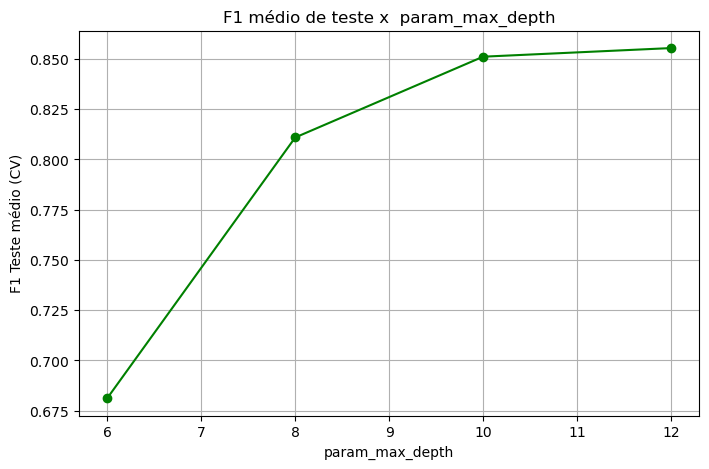

    param_max_depth param_criterion  param_min_samples_split  mean_test_score
12               12            gini                        2         0.882811
8                10            gini                        2         0.874454
28               12         entropy                        2         0.873489
44               12        log_loss                        2         0.873489
13               12            gini                        4         0.870887
9                10            gini                        4         0.868280
24               10         entropy                        2         0.864444
40               10        log_loss                        2         0.864444
45               12        log_loss                        4         0.864305
29               12         entropy                        4         0.864305
41               10        log_loss                        4         0.859187
25               10         entropy                        4    

In [73]:
print('Melhores Hiperparâmetros='+str(model.best_params_))
print('Melhor F1=' + str(model.best_score_))
results = pd.DataFrame(model.cv_results_)

# Agrupa por max_depth e calcula média do mean_test_score
agg_dt = (results
        .groupby('param_max_depth')['mean_test_score']
        .mean()
        .reset_index())

plt.figure(figsize=(8, 5))
plt.plot(agg_dt['param_max_depth'], agg_dt['mean_test_score'], marker='o', color='green')
plt.xlabel('param_max_depth')
plt.ylabel('F1 Teste médio (CV)')
plt.title('F1 médio de teste x  param_max_depth')
plt.grid(True)
plt.show()

print(results[['param_max_depth', 'param_criterion', 'param_min_samples_split', 'mean_test_score']]
    .sort_values(by='mean_test_score', ascending=False)
  .head(15))

========== MÉTRICAS ==========
Tempo de Execução de Testes = 0.0011 segundos
              precision    recall  f1-score   support

           0     0.8970    0.9250    0.9108       160
           1     0.9697    1.0000    0.9846       160
           2     0.8816    0.8375    0.8590       160
           3     0.8987    0.8875    0.8931       160

    accuracy                         0.9125       640
   macro avg     0.9117    0.9125    0.9119       640
weighted avg     0.9117    0.9125    0.9119       640

========== ANÁLISE DE RESULTADOS ==========


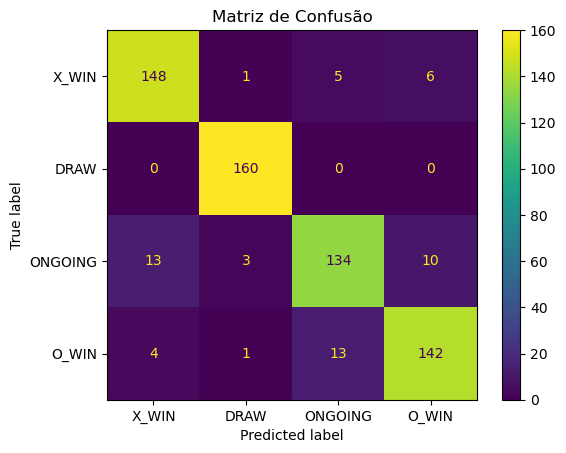

In [75]:
dep.test(model, X_val, y_val)

In [76]:
joblib.dump(model, MODEL_PATH)
print(f'Modelo salvo em {MODEL_PATH}')

Modelo salvo em ../decision_tree.pkl
